In [1]:
!pip install -r requirements.txt --ignore-installed

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached certifi-2024.7.4-py3-none-any.whl.metadata (2.2 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (33 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached contourpy-1.2.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached debugpy-1.8.5-py2.py3-none-any.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached dm_tree-0.1.8-cp310-cp310-macosx_11_0_arm64.whl.metadata (1.9 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
  Using cach

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
df = pd.read_excel(
    "Pedidos.xlsx",
    parse_dates=["DataFechamento"]  # Converte diretamente essa coluna para datetime
)
df.head()

,codigo_produto,descricao_produto,codigo_subcategoria,descricao_subcategoria,codigo_categoria,descricao_categoria,qtde_vendida,valor_unitario,acrescimos,descontos,valor_total,ordem_item,numero_pedido,valor_pedido,DataFechamento
0,709,SKOL LATA,61,CERVEJAS,18,BEBIDAS,1.0,4.0,0.0,0.0,4.0,1,290916,6.5,2017-01-31 21:16:23.060000000
1,710,CONTI GUARANA LATA,62,REFRIGERANTES,18,BEBIDAS,1.0,2.5,0.0,0.0,2.5,2,290916,6.5,2017-01-31 21:16:23.060000000
2,712,DOGAO 1,64,PAO DE HAMBURGUER,19,LANCHES,1.0,15.0,0.0,0.0,15.0,1,290918,19.0,2017-01-31 21:54:56.006666700
3,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,1,290919,22.0,2017-01-31 18:39:32.210000000
4,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,2,290919,22.0,2017-01-31 18:39:32.210000000


In [8]:
# pega todas as colunas numéricas
num_cols = df.select_dtypes(include="number").columns

# remove qtde_vendida da lista
num_cols = num_cols.drop("qtde_vendida")

# arredonda apenas as numéricas restantes
df[num_cols] = df[num_cols].round(2)

df.head()


,codigo_produto,descricao_produto,codigo_subcategoria,descricao_subcategoria,codigo_categoria,descricao_categoria,qtde_vendida,valor_unitario,acrescimos,descontos,valor_total,ordem_item,numero_pedido,valor_pedido,DataFechamento
0,709,SKOL LATA,61,CERVEJAS,18,BEBIDAS,1.0,4.0,0.0,0.0,4.0,1,290916,6.5,2017-01-31 21:16:23.060000000
1,710,CONTI GUARANA LATA,62,REFRIGERANTES,18,BEBIDAS,1.0,2.5,0.0,0.0,2.5,2,290916,6.5,2017-01-31 21:16:23.060000000
2,712,DOGAO 1,64,PAO DE HAMBURGUER,19,LANCHES,1.0,15.0,0.0,0.0,15.0,1,290918,19.0,2017-01-31 21:54:56.006666700
3,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,1,290919,22.0,2017-01-31 18:39:32.210000000
4,713,HAMBURGAO,63,HAMBURGUER,19,LANCHES,1.0,11.0,0.0,0.0,11.0,2,290919,22.0,2017-01-31 18:39:32.210000000


In [9]:
# Dimensão
print("Formato:", df.shape)

# Tipos de dados
print("\nTipos:")
print(df.dtypes)

# Estatísticas numéricas
print("\nEstatísticas:")
print(df.describe())

# Ver valores nulos
print("\nNulos:")
print(df.isnull().sum()) 


Formato: (1048575, 15)

Tipos:
codigo_produto                     int64
descricao_produto                 object
codigo_subcategoria                int64
descricao_subcategoria            object
codigo_categoria                   int64
descricao_categoria               object
qtde_vendida                     float64
valor_unitario                   float64
acrescimos                       float64
descontos                        float64
valor_total                      float64
ordem_item                         int64
numero_pedido                      int64
valor_pedido                     float64
DataFechamento            datetime64[ns]
dtype: object

Estatísticas:
       codigo_produto  codigo_subcategoria  codigo_categoria  qtde_vendida  \
count    1.048575e+06         1.048575e+06      1.048575e+06  1.048575e+06   
mean     7.571760e+02         6.484381e+01      1.883448e+01  1.208557e+00   
min      7.090000e+02         6.100000e+01      1.800000e+01 -2.900000e+01   
25%      7.17

In [10]:
# Ver linhas com valores negativos
linhas_removidas = (df["qtde_vendida"] < 0).sum()
print("Linhas a remover:", linhas_removidas)

df = df[df["qtde_vendida"] >= 0].copy()  

df = df[df["DataFechamento"].dt.year < 2025].copy()


Linhas a remover: 14


In [11]:
df = df.drop_duplicates()

In [12]:
df["valor_calculado"] = df["qtde_vendida"] * df["valor_unitario"] + df["acrescimos"] - df["descontos"]

# Diferença entre o calculado e o informado
df["diferenca"] = (df["valor_total"] - df["valor_calculado"]).round(2)

# Conferir registros inconsistentes
inconsistentes = df[df["diferenca"] != 0]


In [13]:
# Dimensão
print("Formato:", df.shape)

Formato: (1048561, 17)


In [14]:
# Z-score da coluna 'valor_pedido'
z_scores = stats.zscore(df['valor_pedido'])
df_sem_outliers = df[(z_scores > -3) & (z_scores < 3)].copy()

In [15]:
# --- Agregações solicitadas ---
total_pedidos = df_sem_outliers['numero_pedido'].nunique()
valor_medio_pedido = df_sem_outliers['valor_pedido'].mean()
maior_valor_pedido = df_sem_outliers['valor_pedido'].max()
menor_valor_pedido = df_sem_outliers['valor_pedido'].min()
total_itens_vendidos = df_sem_outliers['qtde_vendida'].sum()

# Vendas por categoria
vendas_por_categoria = df_sem_outliers.groupby('descricao_categoria')['valor_total'].sum().reset_index()
vendas_por_categoria = vendas_por_categoria.rename(columns={'valor_total': 'vendas_categoria'})

# Vendas ano a ano
df_sem_outliers['ano'] = df_sem_outliers['DataFechamento'].dt.year
vendas_ano_a_ano = df_sem_outliers.groupby('ano')['valor_total'].sum().reset_index()
vendas_ano_a_ano = vendas_ano_a_ano.rename(columns={'valor_total': 'vendas_ano'})

# Criando um DataFrame resumo geral
resumo_geral = pd.DataFrame({
    'total_pedidos': [total_pedidos],
    'valor_medio_pedido': [valor_medio_pedido],
    'maior_valor_pedido': [maior_valor_pedido],
    'menor_valor_pedido': [menor_valor_pedido],
    'total_itens_vendidos': [total_itens_vendidos]
})

# Mostrando os resultados
print("📊 Resumo Geral:")
print(resumo_geral)
print("\n🏷️ Vendas por categoria:")
print(vendas_por_categoria)
print("\n📅 Vendas ano a ano:")
print(vendas_ano_a_ano)

📊 Resumo Geral:
   total_pedidos  valor_medio_pedido  maior_valor_pedido  menor_valor_pedido  \
0         449122           57.323896               698.0                0.03   

   total_itens_vendidos  
0            1254429.63  

🏷️ Vendas por categoria:
  descricao_categoria  vendas_categoria
0          ACRESCIMOS          12665.52
1        BATATA FRITA          48224.03
2             BEBIDAS        1693709.61
3     D i v e r s o s         133560.68
4               FRIOS           1418.80
5             HOT DOG           1460.00
6             LANCHES       16770651.07
7                  MP            408.64
8               doces           1317.15
9            salgados          22569.28

📅 Vendas ano a ano:
    ano  vendas_ano
0  2017  1326481.12
1  2018  1918827.22
2  2019  1997865.75
3  2020  2471252.19
4  2021  2708327.41
5  2022  3326410.21
6  2023  3967744.51
7  2024   969076.37


In [16]:
print("\n📅 Vendas ano a ano:")
print(vendas_ano_a_ano)


📅 Vendas ano a ano:
    ano  vendas_ano
0  2017  1326481.12
1  2018  1918827.22
2  2019  1997865.75
3  2020  2471252.19
4  2021  2708327.41
5  2022  3326410.21
6  2023  3967744.51
7  2024   969076.37


In [17]:
total_itens_diferentes = df['codigo_produto'].nunique()
print("🛒 Total de itens diferentes:", total_itens_diferentes)

🛒 Total de itens diferentes: 377


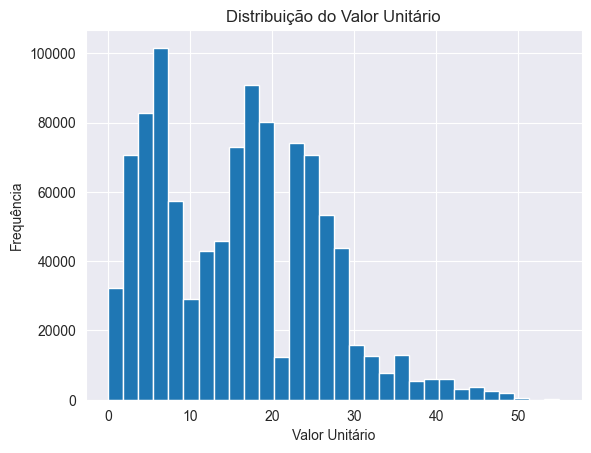

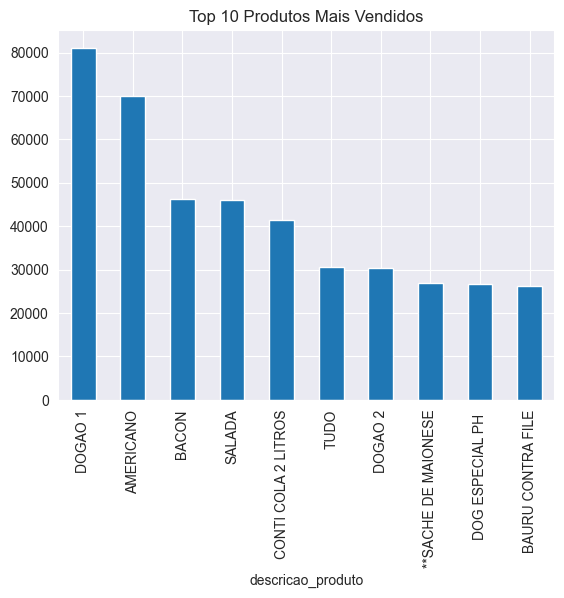

In [18]:
# Histograma de valores unitários
df_sem_outliers["valor_unitario"].hist(bins=30)
plt.title("Distribuição do Valor Unitário")
plt.xlabel("Valor Unitário")
plt.ylabel("Frequência")
plt.show()

# Top 10 produtos mais vendidos
df_sem_outliers["descricao_produto"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Produtos Mais Vendidos")
plt.show()


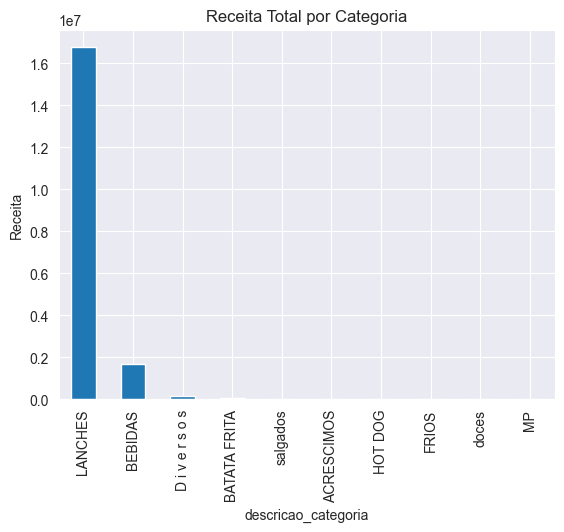

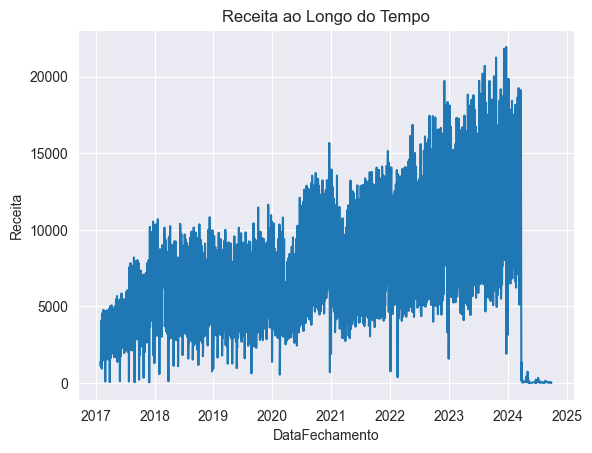

In [20]:
# Receita total por categoria
df_sem_outliers.groupby("descricao_categoria")["valor_total"].sum().sort_values(ascending=False).plot(kind="bar")
plt.title("Receita Total por Categoria")
plt.ylabel("Receita")
plt.show()

# Receita ao longo do tempo
df_sem_outliers.groupby(df_sem_outliers["DataFechamento"].dt.date)["valor_total"].sum().plot()
plt.title("Receita ao Longo do Tempo")
plt.ylabel("Receita")
plt.show()

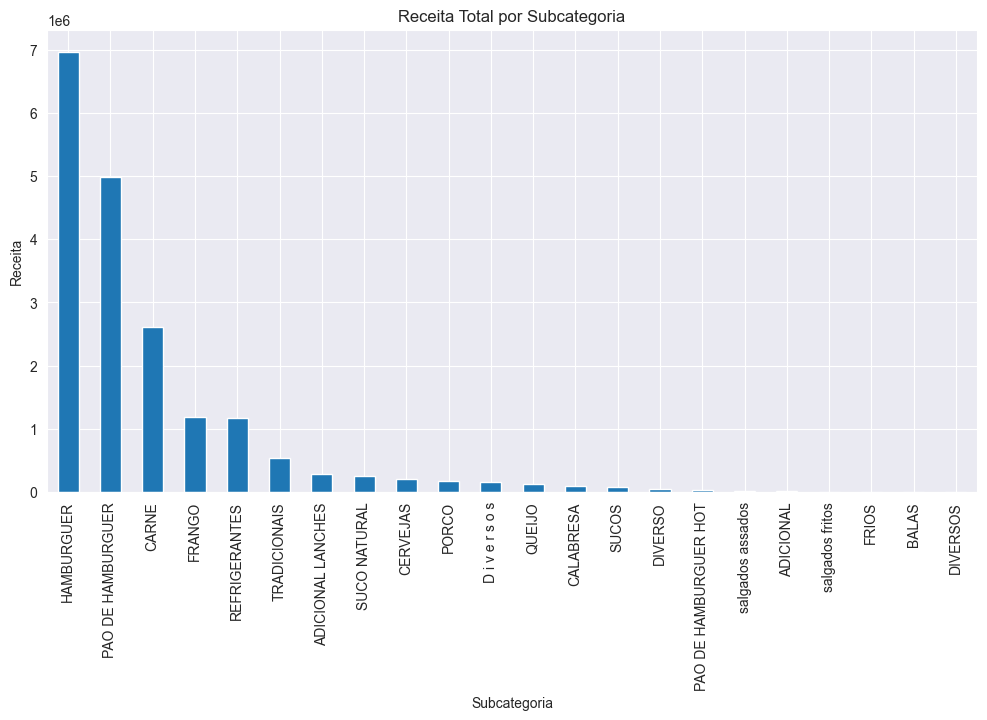

In [21]:
# ================================
# Receita total por subcategoria
# ================================
df.groupby("descricao_subcategoria")["valor_total"].sum().sort_values(ascending=False).plot(kind="bar", figsize=(12,6))
plt.title("Receita Total por Subcategoria")
plt.ylabel("Receita")
plt.xlabel("Subcategoria")
plt.xticks(rotation=90)
plt.show()

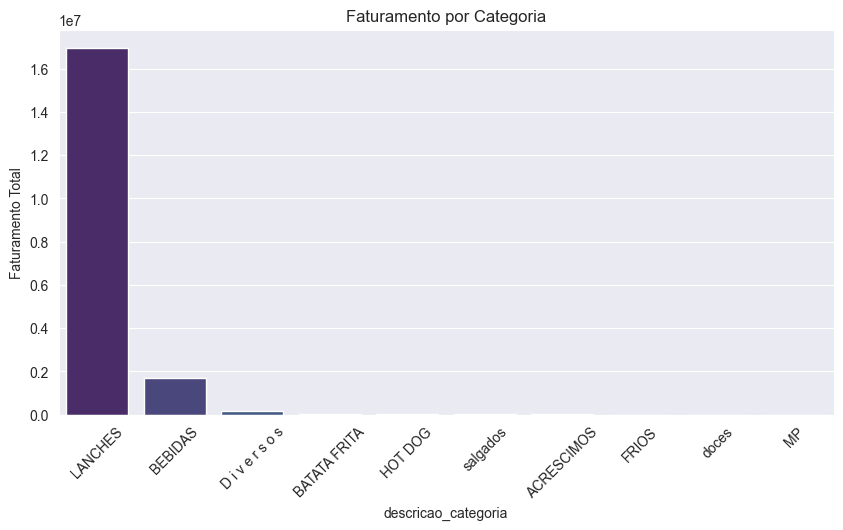

In [23]:
# Total vendido por categoria
vendas_categoria = df.groupby("descricao_categoria")["valor_total"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(
    x=vendas_categoria.index,
    y=vendas_categoria.values,
    hue=vendas_categoria.index,
    palette="viridis",
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel("Faturamento Total")
plt.title("Faturamento por Categoria")
plt.show()

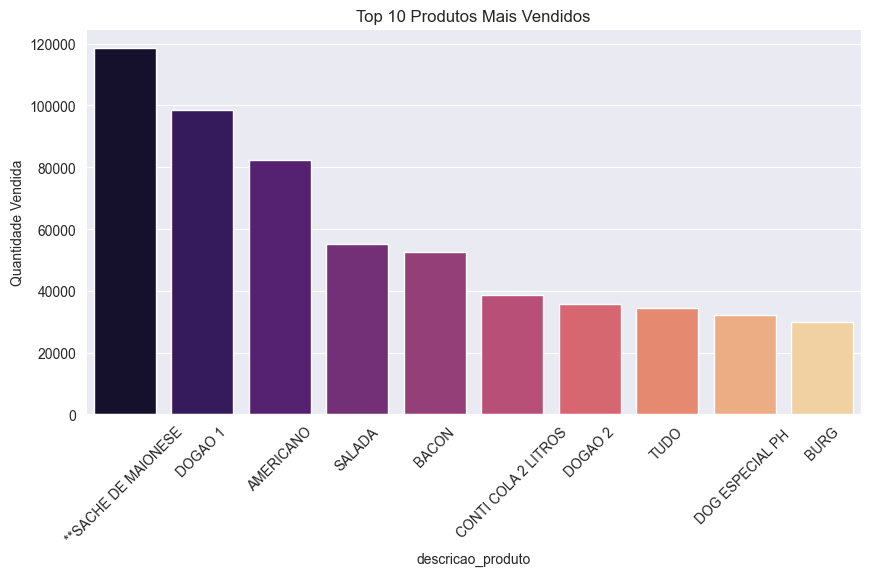

In [24]:
# Top 10 produtos por quantidade vendida
top_produtos = df.groupby("descricao_produto")["qtde_vendida"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(
    x=top_produtos.index,
    y=top_produtos.values,
    hue=top_produtos.index,
    palette="magma",
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel("Quantidade Vendida")
plt.title("Top 10 Produtos Mais Vendidos")
plt.show()

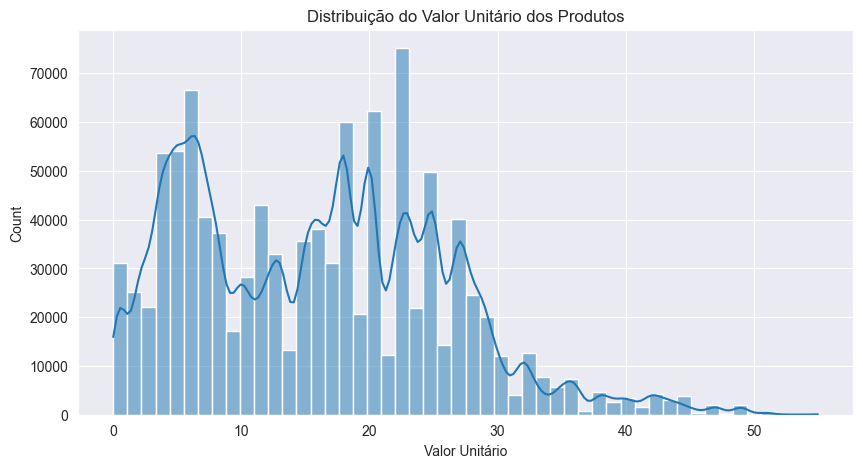

In [25]:
plt.figure(figsize=(10,5))
sns.histplot(df["valor_unitario"], bins=50, kde=True)
plt.xlabel("Valor Unitário")
plt.title("Distribuição do Valor Unitário dos Produtos")
plt.show()

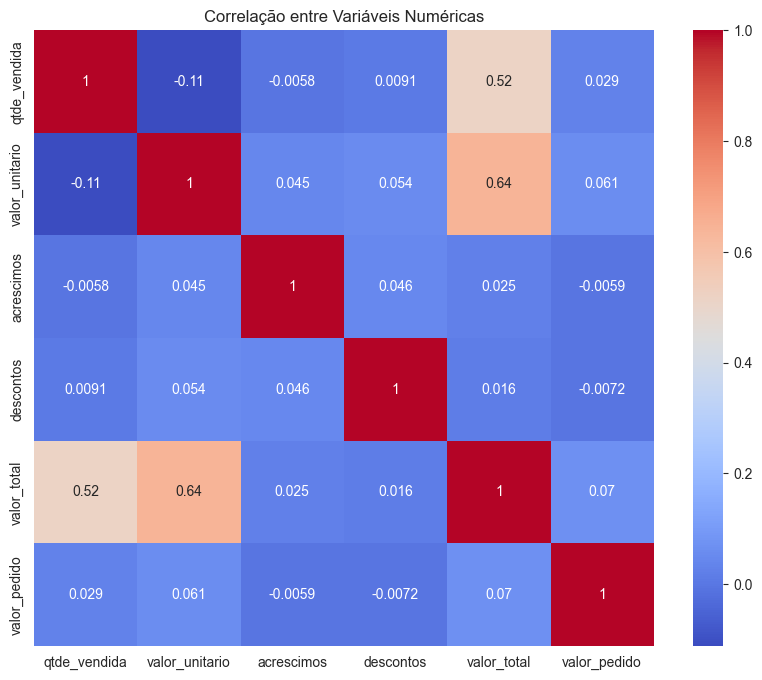

In [26]:
plt.figure(figsize=(10,8))
sns.heatmap(df[["qtde_vendida","valor_unitario","acrescimos","descontos","valor_total","valor_pedido"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis Numéricas")
plt.show()

In [ ]:
# 1️⃣ Criar matriz binária pedido x produto
matriz_binaria = df.pivot_table(
    index='numero_pedido',
    columns='descricao_produto',
    values='qtde_vendida',
    fill_value=0
).map(lambda x: 1 if x > 0 else 0)

# 2️⃣ Filtrar os 100 produtos mais vendidos
top_100_produtos = df.groupby('descricao_produto')['qtde_vendida'].sum().sort_values(ascending=False).head(100).index
matriz_top100 = matriz_binaria[top_100_produtos]

# 3️⃣ Aplicar Apriori para conjuntos maiores
frequent_itemsets = apriori(
    matriz_top100,
    min_support=0.005,   # itemset deve aparecer em pelo menos 1% dos pedidos
    use_colnames=True,
    max_len=5           # pegando conjuntos de até 5 produtos
)

# 4️⃣ Gerar regras de associação mais completas
regras = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
).sort_values(by=['confidence', 'lift'], ascending=False)

# 5️⃣ Criar uma matriz de relações entre todos os produtos
# Inicializa DataFrame vazio
produtos = matriz_top100.columns.tolist()
matriz_relacoes = pd.DataFrame(0, index=produtos, columns=produtos, dtype=float)

# Preenche a matriz com a confiança das regras
for _, row in regras.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    for a in antecedents:
        for c in consequents:
            if a != c:
                matriz_relacoes.loc[a, c] = max(matriz_relacoes.loc[a, c], row['confidence'])

In [52]:
# 6️⃣ Função para pegar os top N produtos relacionados
def produtos_relacionados_avancado_multi(produtos_input, n=5):
    """
    Retorna os n produtos mais relacionados a um ou mais produtos.
    
    produtos_input: str ou lista de str
    n: número de produtos relacionados a retornar
    """
    if isinstance(produtos_input, str):
        produtos_input = [produtos_input]
    
    # Verifica se os produtos existem na matriz
    produtos_validos = [p for p in produtos_input if p in matriz_relacoes.index]
    if not produtos_validos:
        return f"Nenhum dos produtos informados foi encontrado na matriz."

    # Soma as relações dos produtos informados
    soma_relacoes = matriz_relacoes.loc[produtos_validos].sum(axis=0)
    
    # Remove os próprios produtos da lista
    soma_relacoes = soma_relacoes.drop(produtos_validos, errors='ignore')
    
    # Filtra apenas produtos com relação > 0 e ordena
    soma_relacoes = soma_relacoes[soma_relacoes > 0].sort_values(ascending=False)
    
    return soma_relacoes.head(n)

# Realizando "Predição" com Apriori 
print(produtos_relacionados_avancado_multi(["DOGAO 1", "SALADA"]))

CONTI COLA 2 LITROS    0.118331
BACON                  0.104443
BURG                   0.075049
**SACHE DE MAIONESE    0.072268
dtype: float64


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense

In [62]:
print("Versão TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponíveis:", gpus)

if gpus:
    print("TensorFlow detectou a GPU!")
else:
    print("Nenhuma GPU detectada.")

Versão TensorFlow: 2.16.2
GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow detectou a GPU!


In [63]:
# Supondo que seu DataFrame original se chame 'df'
# e já esteja carregado com os dados que você me mostrou
# 1. Criar um DataFrame de interações
# Filtrar apenas as vendas (qtde_vendida > 0)
interacoes = df[df['qtde_vendida'] > 0].copy()

# 2. Codificar os IDs de pedidos e produtos
# A rede neural precisa de números inteiros, não de strings.
pedido_encoder = LabelEncoder()
interacoes['pedido_id'] = pedido_encoder.fit_transform(interacoes['numero_pedido'])

produto_encoder = LabelEncoder()
interacoes['produto_id'] = produto_encoder.fit_transform(interacoes['descricao_produto'])

# Mapear IDs de volta para nomes para referência futura
produtos_map = {idx: produto for idx, produto in enumerate(produto_encoder.classes_)}
pedidos_map = {idx: pedido for idx, pedido in enumerate(pedido_encoder.classes_)}

# Número total de pedidos e produtos únicos
n_pedidos = len(interacoes['pedido_id'].unique())
n_produtos = len(interacoes['produto_id'].unique())

print(f"Total de pedidos únicos: {n_pedidos}")
print(f"Total de produtos únicos: {n_produtos}")

# 3. Separar os dados em treino e teste
X = interacoes[['pedido_id', 'produto_id']]
# A variável 'y' representa a interação.
# Como já filtramos para qtde_vendida > 0, todos os valores são 1.
# Não precisamos de uma variável 'y' explícita neste modelo, pois
# a interação é o próprio par (pedido, produto)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

Total de pedidos únicos: 449285
Total de produtos únicos: 377


In [64]:
# Tamanho do embedding (hiperparâmetro)
embedding_size = 50

# Inputs
pedido_input = Input(shape=(1,))
produto_input = Input(shape=(1,))

# Embeddings
pedido_embedding = Embedding(input_dim=n_pedidos, output_dim=embedding_size, name='pedido_embedding')(pedido_input)
produto_embedding = Embedding(input_dim=n_produtos, output_dim=embedding_size, name='produto_embedding')(produto_input)

# Flatten
pedido_vec = Flatten()(pedido_embedding)
produto_vec = Flatten()(produto_embedding)

# Concatenar embeddings
x = Concatenate()([pedido_vec, produto_vec])

# Camadas densas
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Probabilidade de interação

# Modelo
model = Model(inputs=[pedido_input, produto_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


2025-09-09 22:58:56.761371: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-09-09 22:58:56.761430: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-09-09 22:58:56.761454: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-09-09 22:58:56.761503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-09 22:58:56.761524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pedido_embedding    │ (None, 1, 50)     │ 22,464,250 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ produto_embedding   │ (None, 1, 50)     │     18,850 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ pedido_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ produto_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,504,349 (85.85 MB)

 Trainable params: 22,504,349 (85.85 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
import numpy as np

# Criar pares negativos
n_positivos = len(X_train)
neg_pedidos = np.random.choice(X_train['pedido_id'], size=n_positivos)
neg_produtos = np.random.choice(X_train['produto_id'], size=n_positivos)

# Combinar positivos e negativos
X_train_neg = pd.DataFrame({
    'pedido_id': np.concatenate([X_train['pedido_id'], neg_pedidos]),
    'produto_id': np.concatenate([X_train['produto_id'], neg_produtos])
})
y_train = np.concatenate([np.ones(n_positivos), np.zeros(n_positivos)])

# Mesmo para teste
n_test = len(X_test)
neg_pedidos_test = np.random.choice(X_test['pedido_id'], size=n_test)
neg_produtos_test = np.random.choice(X_test['produto_id'], size=n_test)
X_test_neg = pd.DataFrame({
    'pedido_id': np.concatenate([X_test['pedido_id'], neg_pedidos_test]),
    'produto_id': np.concatenate([X_test['produto_id'], neg_produtos_test])
})
y_test = np.concatenate([np.ones(n_test), np.zeros(n_test)])


In [ ]:
history = model.fit(
    [X_train_neg['pedido_id'], X_train_neg['produto_id']],
    y_train,
    validation_data=([X_test_neg['pedido_id'], X_test_neg['produto_id']], y_test),
    epochs=10,
    batch_size=256
)


Epoch 1/10
